# HD현대 AI Challenge


*   대회 링크: https://dacon.io/competitions/official/236158/overview/description

### [주제]
항만 內 선박 대기 시간 예측을 위한 선박 항차 데이터 분석 AI 알고리즘 개발

### [대회 개요]
알고리즘 | 채용 | 정형 | 조선해양 | 회귀 | MAE

### [데이터셋]
* 'ARI_CO': 도착항의 소속국가(도착항 앞 2글자)
* 'ARI_PO': 도착항의 항구명(도착항 뒤 글자)
* 'SHIP_TYPE_CATEGORY': 선종 통합 바탕으로 5대 선종으로 분류
* 'DIST': 정박지(ber_port)와 접안지 사이의 거리
* 'ATA': anc_port에 도착한 시점의 utc. 실제 정박 시각(Actual Time of Arrival)
* 'ID': 선박식별 일련번호
* 'BREADTH': 선박의 폭
* 'BUILT': 선박의 연령
* 'DEADWEIGHT': 선박의 재화중량톤수
* 'DEPTH': 선박의 깊이
* 'DRAUGHT': 흘수 높이
* 'GT': 용적톤수(Gross Tonnage)값
* 'LENGTH': 선박의 길이
* 'SHIPMANAGER': 선박 소유주
* 'FLAG': 선박의 국적
* 'U_WIND': 풍향 u벡터
* 'V_WIND': 풍향 v벡터
* 'AIR_TEMPERATURE': 기온
* 'BN': 보퍼트 풍력 계급
* 'ATA_LT': anc_port에 도착한 시점의 현지 정박 시각(Local Time of Arrival)(단위 : H)
* 'PORT_SIZE': 접안지 폴리곤 영역의 크기
* 'CI_HOUR': 대기시간


## Import & Data Load
데이터를 불러옴.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
PROJECT_DIR = '/content/drive/MyDrive/대회 실습/데이콘 현대'
os.listdir(PROJECT_DIR)

['test.csv', 'sample_submission.csv', 'train.csv', 'baseline_submit.csv']

In [4]:
os.path.join(PROJECT_DIR, 'train.csv')
os.path.join(PROJECT_DIR, 'test.csv')
os.path.join(PROJECT_DIR, 'sample_submission.csv')

'/content/drive/MyDrive/대회 실습/데이콘 현대/sample_submission.csv'

In [5]:
train = pd.read_csv(os.path.join(PROJECT_DIR, 'train.csv')).drop(columns=['SAMPLE_ID'])
test = pd.read_csv(os.path.join(PROJECT_DIR, 'test.csv')).drop(columns=['SAMPLE_ID'])

## Data Pre-processing

* 'ATA'열을 여러 개의 파생 변수로 변환
* 범주형 변수를 인코딩
* 결측치를 평균값으로 채움

In [53]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|██████████| 6/6 [00:02<00:00,  2.72it/s]


* 타깃 변수에 영향을 주지 않을 것으로 예상 되는 열들을 삭제

In [54]:
# 불필요한 열 삭제
train.drop(['SHIPMANAGER','minute','ID','hour'],axis=1, inplace=True)
test.drop(['SHIPMANAGER','minute','ID','hour'],axis=1, inplace=True)

* 'month'변수를 이용해서 새로운 계절 변수인 'season'을 생성

In [55]:
# month를 계절로 변환
def get_season(x) :

    if x in [9, 10, 11] :
        return 3
    elif x in [12, 1, 2] :
        return 2
    elif x in [3, 4, 5, 6] :
        return 1
    else :
        return 0

train['season'] = train['month'].apply(get_season)
test['season'] = test['month'].apply(get_season)

* 실제 선박에서 사용되는 비율 계산해서 열 추가

In [56]:
# 실제 선박 사용 비율
train['Utilization Rate'] = (train['DEADWEIGHT'] / train['GT'])*100
test['Utilization Rate'] = (test['DEADWEIGHT'] / test['GT'])*100

* 접안지와 정박지 사이 거리에서 실제 선박이 차지하는 길이의 비율 계산해서 열 추가

In [57]:
# 접안지와 정박지 사이 거리에서 선박 길이의 비율
train['ship_location'] = train['DIST'] / train['LENGTH']
test['ship_location'] = test['DIST'] / test['LENGTH']

* 선박의 부피 계산해서 열 추가

In [58]:
# 선박의 부피
train['ship_volume'] = train['BREADTH'] * train['DEPTH'] * train['LENGTH']
test['ship_volume'] = test['BREADTH'] * test['DEPTH'] * test['LENGTH']

* 24시간을 새벽, 아침, 오후, 저녁으로 나눠서 열 추가

In [59]:
# 24시간을 새벽, 아침, 오후, 저녁으로 나눔
def ATA_LT(train): # O
    train.loc[(train['ATA_LT'] < 6), 'train'] = 0
    train.loc[(train['ATA_LT'] >=6) & (train['ATA_LT'] < 12), 'train'] = 1
    train.loc[(train['ATA_LT'] >= 12) & (train['ATA_LT'] < 19), 'train'] = 2
    train.loc[(train['ATA_LT'] >= 19) & (train['ATA_LT'] <= 23), 'train'] = 3
    return train['ATA_LT']

def ATA_LT(test): # O
    test.loc[(test['ATA_LT'] < 6), 'test'] = 0
    test.loc[(test['ATA_LT'] >=6) & (test['ATA_LT'] < 12), 'test'] = 1
    test.loc[(test['ATA_LT'] >= 12) & (test['ATA_LT'] < 19), 'test'] = 2
    test.loc[(test['ATA_LT'] >= 19) & (test['ATA_LT'] <= 23), 'test'] = 3
    return test['ATA_LT']

* 일주일을 평일과 주말로 나눠서 열 추가

In [61]:
# 평일과 주말로 나눔
def weekday(train):
    train.loc[(train['weekday'] < 5), 'train'] = 0
    train.loc[(train['weekday'] >=5), 'train'] = 1
    return train['weekday']

def weekday(test):
    test.loc[(test['weekday'] < 5), 'test'] = 0
    test.loc[(test['weekday'] >=5), 'test'] = 1
    return test['weekday']

* 풍향 u벡터와 v벡터를 사용하여 바람 속도 계산한 뒤 열 추가

In [62]:
# 바람 속도 열 생성
def calculate_wind_speed(u_vector, v_vector):
    return np.sqrt(u_vector**2 + v_vector**2)

train['WIND_SPEED'] = calculate_wind_speed(train['U_WIND'], train['V_WIND'])
test['WIND_SPEED'] = calculate_wind_speed(test['U_WIND'], test['V_WIND'])

In [65]:
def boolean_to_numeric(df):
    return df.astype(float)
train = boolean_to_numeric(train)
test = boolean_to_numeric(test)

* 'CI_HOUR'의 왜도 현상을 개선하기 위해 로그 취함

In [66]:
train['CI_HOUR'] = np.log1p(train['CI_HOUR'])

## 모델 학습 및 특성 중요도 확인

Model Tune for LGBM.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3192
[LightGBM] [Info] Number of data points in the train set: 391939, number of used features: 27
[LightGBM] [Info] Start training from score 2.163316


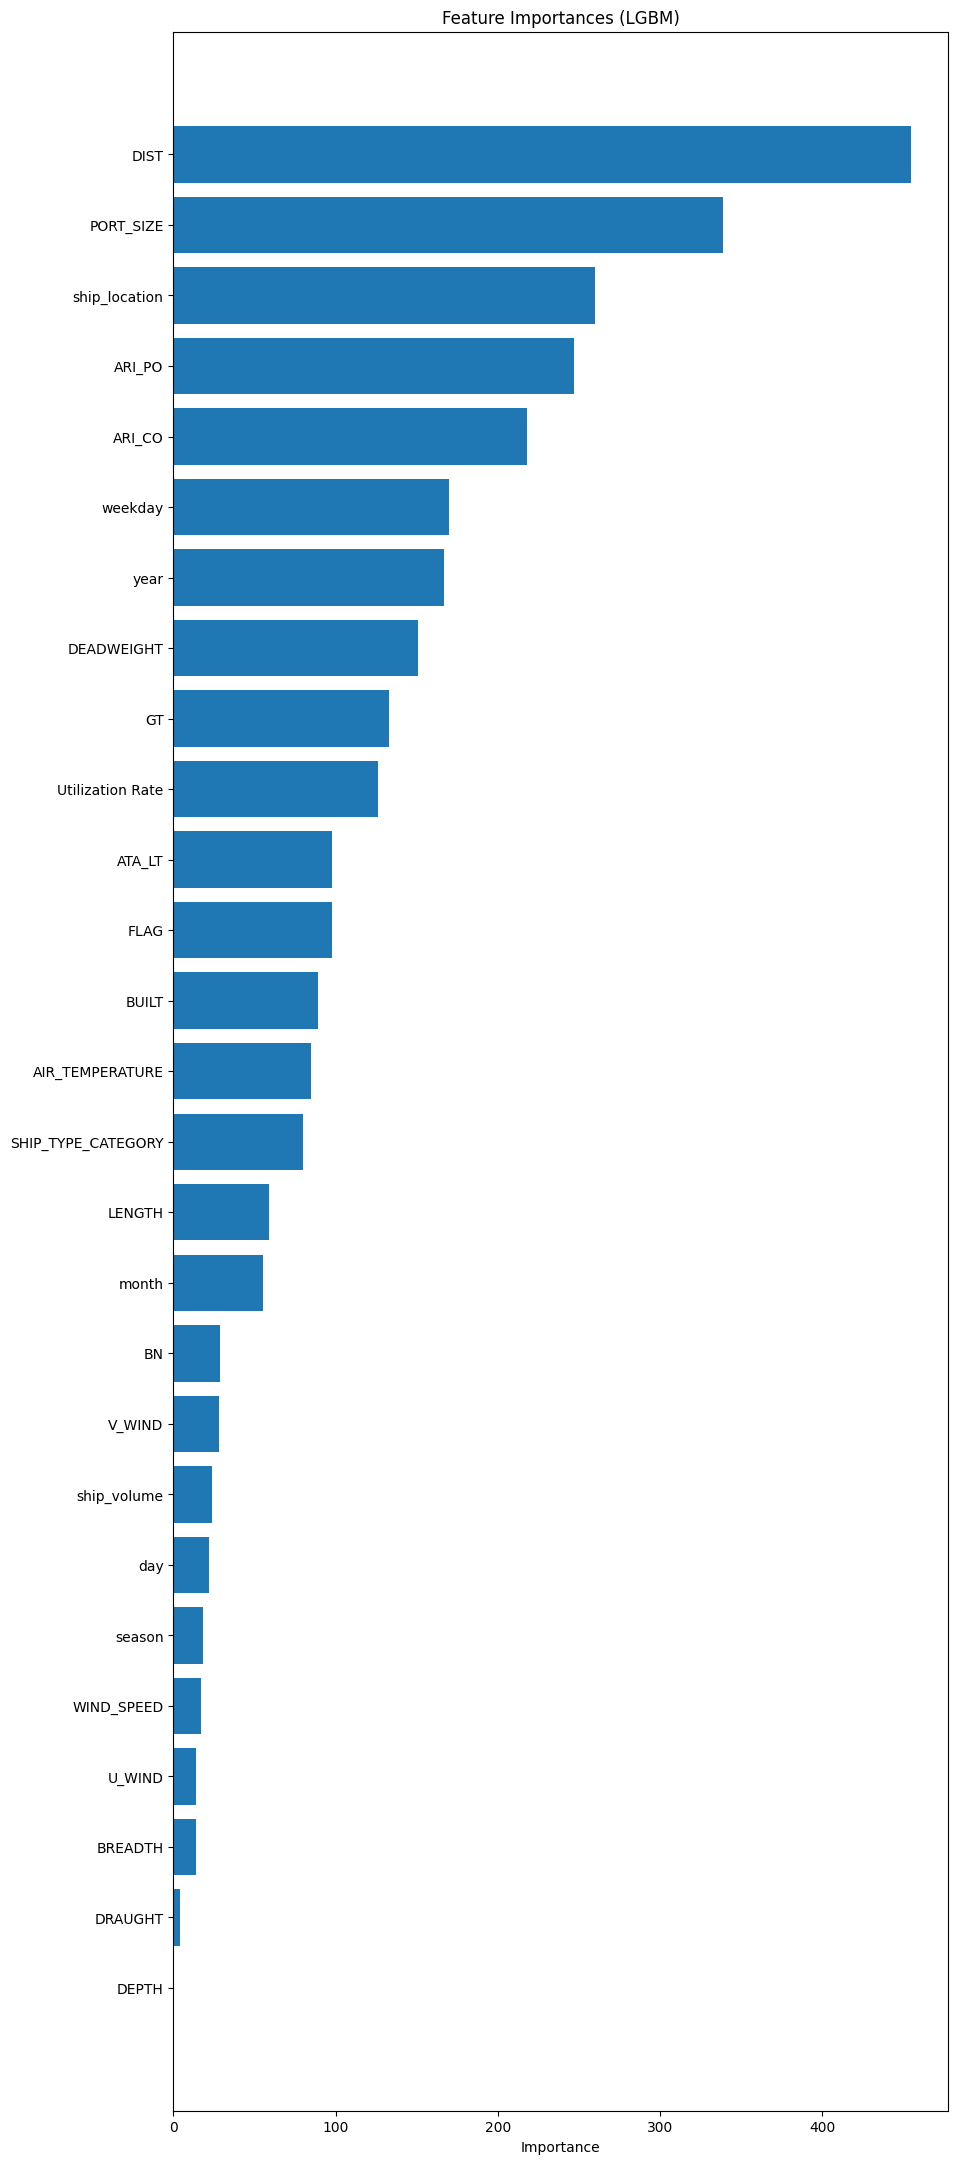

In [67]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

* StandarScaler를 사용하여 데이터를 표준화

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaler.fit(X_train)
X_train.loc[:, :] = scaler.transform(X_train)
test.loc[:, :] = scaler.transform(test)

test.head(2)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,...,PORT_SIZE,year,month,day,weekday,season,Utilization Rate,ship_location,ship_volume,WIND_SPEED
0,1.531978,-0.794686,1.852677,-0.565845,1.775113,0.461672,0.841094,2.236853,1.937669,1.721203,...,2.075833,0.379552,-0.128136,0.257618,0.328244,-0.552082,-1.128957,-0.493517,2.758976,-0.305694
1,-0.502686,1.608274,0.872508,0.196288,-1.875507,-0.248154,-0.940992,-1.071166,-0.236581,-0.986884,...,0.180762,0.793630,-0.417396,1.171141,-0.221429,-0.552082,-0.145210,0.986368,-0.973918,0.373404


* 중요도가 낮은 변수 제거 (이 코드에서는 제거하지 않았음)

In [69]:
threshold = 0
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

## K-Fold Model Fitting & Validation

* GridSearch를 사용하여 최적의 하이파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor()

parameters = {
    'max_depth': [4,8,9],
    # 'n_estimators': [500, 1000],
    # 'learning_rate': [0.4]
}

xgb_grid = GridSearchCV(xgb, parameters, cv=5, n_jobs=5, verbose=5)
xgb_grid.fit(X_train_reduced, y_train)
scores = pd.DataFrame(xgb_grid.cv_results_)
scores[['params','mean_test_score', 'rank_test_score', 'split0_test_score','split1_test_score', 'split2_test_score']]

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
0.8296980356846095
{'max_depth': 8}


* XGBRegressor를 사용하여 모델 학습

In [49]:
import xgboost
xgb = xgboost.XGBRegressor(max_depth=7)

# 5-Fold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=22)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=5, desc="Processing folds"):
    X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
    y_t, y_val = y_train[train_idx], y_train[val_idx]

    # 두 모델 모두 학습
    xgb.fit(X_t, y_t)

    # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
    val_pred = xgb.predict(X_val)

    # Validation set에 대한 대회 평가 산식 계산 후 저장
    scores.append(mean_absolute_error(y_val, val_pred))

    # test 데이터셋에 대한 예측 수행 후 저장
    xgb_pred = xgb.predict(X_test_reduced)
    xgb_pred = np.where(xgb_pred < 0, 0, xgb_pred)

    ensemble_predictions.append(xgb_pred)

# K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
final_predictions = np.mean(ensemble_predictions, axis=0)

# 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
print("Validation : MAE scores for each fold:", scores)
print("Validation : MAE:", np.mean(scores))


Processing folds: 10it [01:17,  7.74s/it]

Validation : MAE scores for each fold: [0.519517202909909, 0.518292034932155, 0.5195915050293096, 0.5203911776471822, 0.519960516244094, 0.5220798594332052, 0.5239595759768806, 0.5199388147299474, 0.5209173002132992, 0.5154103971548395]
Validation : MAE: 0.5200058384270823


* 실제값과 예측값 비교를 시각화

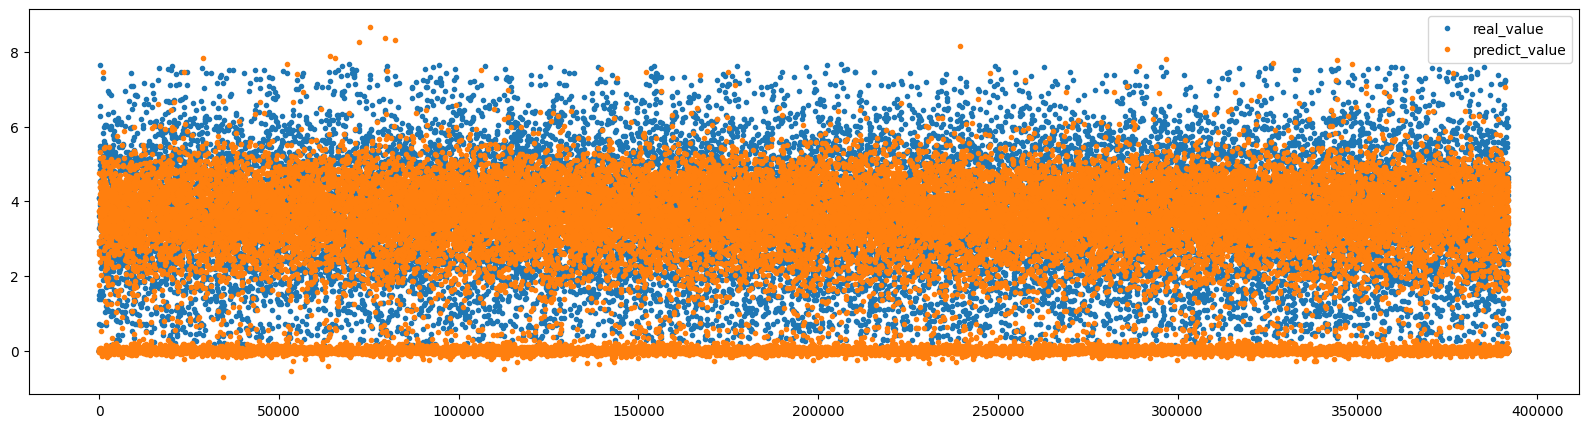

In [31]:
# 실제값과 예측값 비교 시각화
plt.figure(figsize=(20,5))
plt.plot(y_val.index, y_val.values, '.', label='real_value')
plt.plot(y_val.index, val_pred, '.', label='predict_value')
plt.legend(loc='best')

## Submission

* 로그를 취했던 타깃 변수에 지수함수를 사용해 원상복귀

In [50]:
final_predictions = np.expm1(final_predictions)

In [51]:
submit = pd.read_csv(os.path.join(PROJECT_DIR, 'sample_submission.csv'))
submit['CI_HOUR'] = final_predictions
submit.to_csv('./baseline_submit.csv', index=False)